<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/4%20-%20Networks/6.439%20-%20Problem%20Set%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021
***
***

# Part 0 (Execute first!)

In [1]:
# Set load = True to load co-offending network (faster)
load = True

In [2]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS4_data.zip

# Unzip
!unzip -o PS4_data.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import warnings
import scipy

import numpy  as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt
import networkx          as nx 

from tqdm.auto import tqdm, trange

In [3]:
# Function to create or loadd the co-offending network
def create_co_off_network(co_off, load=True, save=True):
  if not load:
    # Obtain crime events
    crime_events = co_off['event_id'].unique()

    # Loop over the crime events
    for event in tqdm(crime_events):

      # Restrict dataset to current event_id
      event_data = co_off[co_off['event_id'] == event]

      # Obtain list of offenders
      offenders = event_data['offender_id'].to_numpy()

      # Cycle through offenders to increase by 1 their co-offending weight
      for i,offender_i in enumerate(offenders):
        for offender_j in offenders[i:]:
          co_off_network[offender_i, offender_j] += 1
          co_off_network[offender_j, offender_i] += 1
    
    # Save sparse matrix
    if save:
      co_off_network_coo = co_off_network.tocoo(copy=True)
      scipy.sparse.save_npz('co_off_network.npz', co_off_network_coo)
      del co_off_network_coo
    
  else:
    co_off_network_coo = scipy.sparse.load_npz('co_off_network.npz')
    co_off_network = co_off_network_coo.todok(copy=True)
    del co_off_network_coo
  
  return co_off_network

In [43]:
def remove_solo_offenders(network):
  print(network.shape)
  # Number of nodes
  number_of_nodes = network.shape[0]

  # Convert to lil for faster row slicing
  network = network.tolil()

  # Initialize nodes no be removed
  to_keep = []

  # Check with nodes are solo offender
  for i in tqdm(range(number_of_offenders)):
    # Obtain view of the row
    row_i = network.getrowview(i)

    # Check if is a solo offender
    if len(row_i.rows[0]) > 1:
      to_keep.append(i)

  # Remove solo offenders
  network = network[to_keep]

  print(network.shape)
  # Return to dok format
  network = scipy.sparse.dok_matrix(network, shape=(number_of_nodes, number_of_nodes))

  return network

# Problem 4.2: Co-offending Network

## Preamble

In [5]:
# Load data
co_off = pd.read_csv("Cooffending.csv")

# Set date
co_off['date'] = pd.to_datetime(co_off['date'])

## (a), (b), (c), (d): Data exploration

This dataset contains 1,465,786 entries. Each observation is taken at the `offender_id`-`event_id`-`crime_code` level. This is, individual offenders arrested at a given crime event and charged with a certain crime. 

Note that at any given crime event, the offender can be charged several different crimes.





In [6]:
co_off.shape[0]

1465786

Within, the number of unique offenders is 538,851, and the number of different crime events are 1,163,423, which occurred between 197 and 2004 according to the following table:

| Year | Number of arrests |
|:--:|:--:|
| 1997 |	22404  |
| 1998 |	142582 |
| 1999 |	163346 |
| 2000 |	220197 |
| 2001 |	234495 |
| 2002 |	246397 |
| 2003 |	251298 |
| 2004 |	185067 |

In [7]:
co_off[['offender_id', 'event_id']].describe(include='all')

,offender_id,event_id
count,1465786.0000,1465786.0000
mean,281089.4558,581615.2382
std,143657.5503,335671.5310
min,0.0000,0.0000
25%,164215.0000,290578.2500
50%,284490.0000,581769.5000
75%,402317.7500,872052.0000
max,538850.0000,1163422.0000


In [8]:
co_off[['offender_id', 'year']].groupby(['year']).count()

,offender_id
year,
1997,22404
1998,142582
1999,163346
2000,220197
2001,234495
2002,246397
2003,251298
2004,185067


We can observe a total of 301 different crime codes (different offenses). The 5 crimes with the most offenders are:

| Crime code | Number of offenders |
|:----------:|:-------------------:|
| 22         |  140,901            |
| 131        |  108,031            |
| 61         |   94,655            |
| 39         |   90,179            |
| 73         |   83,110            |
| <b> Total  |  516,876            |

Together, the comprise a total of 516,876 perpetrators, which correspond to, approximately, 35% of the sample.

In the rest, there is high variability, and apparently a great number of crimes with low occurences (see figure below).

In [9]:
print("Number of unique crime codes:", co_off['crime_code'].unique().size)

Number of unique crime codes: 301


In [10]:
group_by_code = co_off.groupby('crime_code').count()

In [11]:
most_offenders = group_by_code.sort_values(by='offender_id', ascending=False).iloc[:5,:]
most_offenders['offender_id']

crime_code
22     140901
131    108031
61      94655
39      90179
73      83110
Name: offender_id, dtype: int64

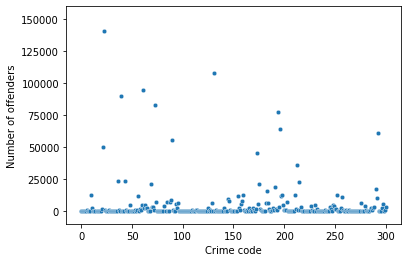

In [12]:
# Axis offsets
offset = (15,10000)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code, x='crime_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [50 * k for k in range(7)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [25000 * k for k in range(7)]
ylabels = yticks

plt.yticks(yticks, ylabels)
plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

To gain more insight, the sample is restricted to crimes with less or equal than 5,000 offenders. For reference, the average number of offenders per crime is, approximately, 4,869. With this, of the 294 different codes, 254 (86.3%) remain.

The plot changes slightly. Most of the codes have little offenders and, among the rest, there is high variability.

In [13]:
group_by_code_small = group_by_code[group_by_code['offender_id'] <= 5000]
group_by_code_small.shape

(254, 9)

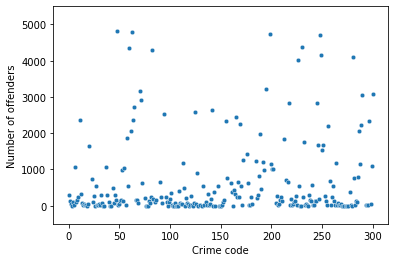

In [14]:
# Axis offsets
offset = (15,500)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code_small, x='crime_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [50 * k for k in range(7)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [1000 * k for k in range(6)]
ylabels = yticks

plt.yticks(yticks, ylabels)
plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

In terms of location, the most notorious crimes occur principally in county 682. This could be the most populated county of the database. In fact, for crime 131, this county accounts for 84,952 offenders. This corresponds to, approximately, 78.63% of all offenders arrested for this crime. The following table shows the contribution of this county alone to all the crimes with most offenders:

| Crime code | Offenders in county 682 | Total offenders | Contribution (%) |
|:----------:|:-----------------------:|:---------------:|:----------------:|
| 131       | 84,952                   | 108,031         | 78.63%
|  22       | 28,247                   | 140,901         | 20.05%
|  61       | 24,101                   |  94,655         | 25.46%
|  73       | 23,743                   |  83,110         | 28.57%
|  39       | 21,698                   |  90,179         | 24.06% 

To see the relevance of this county, the following table shows, for each crime, in how many different counties it occured. Additionally, the table shows the contribution each county should have if crimes occured uniformly in each one. This contribution is computed as follows:
  $$ \text{Contribution}_{\,\text{crime}} = \frac{100}{\text{Number of different counties}_{\,\text{crime}}} $$
<br>

| Crime code | Number of different counties | Uniform contribution |
|:----------:|:----------------------------:|:---------:|
| 131        |   652                        | 0.15%
|  22        | 1,228                        | 0.08%
|  61        | 1,084                        | 0.09%
|  73        | 1,099                        | 0.09%
|  39        | 1,212                        | 0.08%

In [15]:
most_offenders_list = most_offenders.index.to_numpy()
location_of_most_offenders = co_off[co_off['crime_code'].isin(most_offenders_list)]

In [16]:
location_of_most_offenders.groupby(by=['crime_code', 'county']).count().sort_values(by='offender_id').iloc[-5:]

,,offender_id,event_id,adults,date,minors,sex,year,location
crime_code,county,,,,,,,,
39,682,21698,21698,21698,21698,21698,21698,21698,21698
73,682,23743,23743,23743,23743,23743,23743,23743,23743
61,682,24101,24101,24101,24101,24101,24101,24101,24101
22,682,28247,28247,28247,28247,28247,28247,28247,28247
131,682,84952,84952,84952,84952,84952,84952,84952,84952


In [17]:
for crime in most_offenders_list:
  data = location_of_most_offenders[location_of_most_offenders['crime_code'] == crime]
  number_of_counties = data['county'].unique().size
  print(f"Crime code {crime} occured in {number_of_counties} different counties.")

Crime code 22 occured in 1228 different counties.
Crime code 131 occured in 652 different counties.
Crime code 61 occured in 1084 different counties.
Crime code 39 occured in 1212 different counties.
Crime code 73 occured in 1099 different counties.


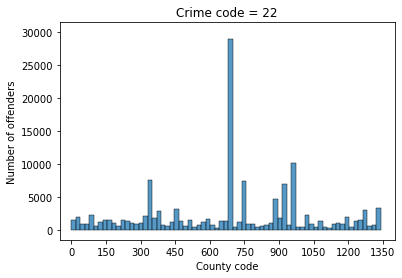

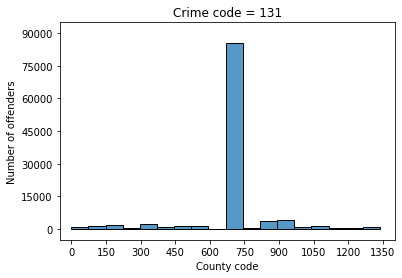

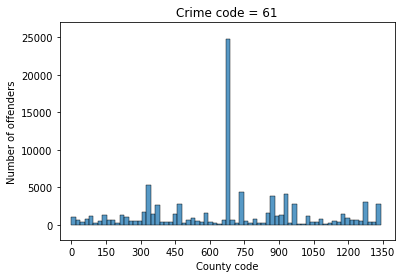

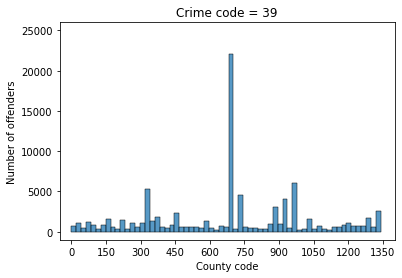

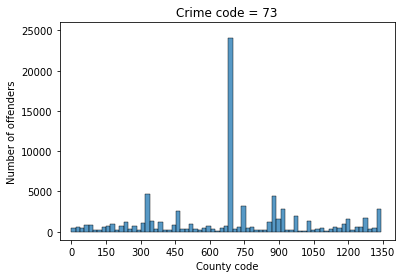

In [18]:
# Axis offsets
offset_x = 50

# yticks dict
yticks_dict = { 22 : ([ 5000 * k for k in range(7)], 1500),
               131 : ([15000 * k for k in range(7)], 5000),
                61 : ([ 5000 * k for k in range(6)], 2000),
                39 : ([ 5000 * k for k in range(6)], 1000),
                73 : ([ 5000 * k for k in range(6)], 1000)
              }

for crime in most_offenders_list:
  # Initialize figure
  fig, ax = plt.subplots()

  # Draw histplot using offender_id count as y-axis
  data = location_of_most_offenders[location_of_most_offenders['crime_code'] == crime]
  sns.histplot(data, x='county')

  # Set xticks
  xticks = [150 * k for k in range(10)]
  xlabels = xticks

  plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
  plt.xlim(xticks[0] - offset_x, xticks[-1] + offset_x)

  # Set yticks
  yticks, offset_y = yticks_dict[crime]
  ylabels = yticks

  plt.yticks(yticks, ylabels)
  plt.ylim(yticks[0] - offset_y, yticks[-1] + offset_y)

  # Set axis titles
  plt.xlabel("County code")
  plt.ylabel("Number of offenders")

  # Set title
  plt.title(f"Crime code = {crime}")

  fig.show()

## (e), (f), (g): Create and analyze the network

To construct the co-offending network, the total number of offenders in the database is obtained. This, since this number determines the size of the co-offending adjacency matrix.

Additionally, the sparse matrix object is initialized.

Then, the network is created.

In [60]:
def remove_solo_offenders(network):
  # Number of nodes
  number_of_nodes = network.shape[0]

  # Initialize dictionary that tells which rows are set to 0
  update_row_dict = {k[0]: False for k in list(network.keys())}

  # Convert to lil for faster row slicing
  network_copy = network.tolil(copy=True)

  # Check with nodes are solo offender
  for i in tqdm(range(number_of_offenders)):
    # Obtain view of the row
    row_i = network_copy.getrowview(i)

    # Check if is a solo offender
    if len(row_i.rows[0]) > 1:
      update_row_dict[i] = True
    
  # Save memory
  del network_copy

  # Construct update dictionary
  network_update_dict = {k: 0 
                         for k, (row, update_row) in zip(network.keys(), 
                                                         update_row_dict.items()) 
                         if update_row
                         }

  # Update network
  # network.update(network_update_dict)

  return network_update_dict

In [61]:
# Initialize parameters
number_of_offenders = co_off['offender_id'].unique().size

# Initialize network as sparse DoK matrix
co_off_network = scipy.sparse.dok_matrix((number_of_offenders,number_of_offenders), dtype='int')

# Create network
co_off_network = create_co_off_network(co_off, load=True)

After eliminating the solo offenders, the network contains a total of 717,223 edges. These include self co-offending. If restricted only to edges  

In [63]:
print(update_dict)

{(4, 4): 0, (451984, 4): 0, (460816, 4): 0, (10, 10): 0, (538316, 10): 0, (12, 12): 0, (401250, 12): 0, (17, 17): 0, (345898, 17): 0, (24, 24): 0, (327232, 24): 0, (27, 27): 0, (28, 27): 0, (30, 30): 0, (31, 31): 0, (32, 32): 0, (32, 34): 0, (33, 34): 0, (38, 38): 0, (39, 39): 0, (40, 40): 0, (41, 40): 0, (46, 46): 0, (172084, 46): 0, (50, 50): 0, (51, 51): 0, (72, 72): 0, (73, 73): 0, (74, 74): 0, (79, 79): 0, (80, 80): 0, (81, 81): 0, (82, 82): 0, (99, 99): 0, (100, 100): 0, (106, 106): 0, (107, 107): 0, (108, 108): 0, (109, 109): 0, (126, 126): 0, (127, 127): 0, (128, 128): 0, (129, 129): 0, (130, 130): 0, (137, 137): 0, (138, 138): 0, (139, 139): 0, (327218, 142): 0, (378772, 142): 0, (145, 145): 0, (146, 146): 0, (154, 154): 0, (155, 155): 0, (157, 158): 0, (158, 158): 0, (162, 162): 0, (163, 163): 0, (174, 174): 0, (175, 175): 0, (209, 209): 0, (210, 210): 0, (211, 211): 0, (212, 212): 0, (234, 234): 0, (235, 235): 0, (236, 236): 0, (237, 237): 0, (72716, 237): 0, (245, 245): 0, 

In [62]:
# Remove solo offenders
# co_off_network = remove_solo_offenders(co_off_network)
update_dict = remove_solo_offenders(co_off_network)

# Compute number of nodes and edges
total_nodes = co_off_network.shape[0]
total_edges = len(co_off_network.keys())//2 + (co_off_network.diagonal() != 0).sum()//2

# Print number of nodes and edges
print(f"There are a total of {total_nodes} nodes")
print(f"There are a total of {total_edges} edges.")

  0%|          | 0/538851 [00:00<?, ?it/s]

There are a total of 538851 nodes
There are a total of 717222 edges.


In [46]:
print(co_off_network)

  (0, 4)	2
  (82356, 4)	1
  (85294, 4)	1
  (1, 10)	2
  (120792, 10)	1
  (2, 12)	2
  (66500, 12)	1
  (3, 17)	2
  (51413, 17)	1
  (4, 24)	2
  (47075, 24)	1
  (5, 27)	2
  (6, 27)	1
  (5, 28)	1
  (6, 28)	2
  (7, 32)	2
  (8, 32)	1
  (9, 32)	1
  (7, 33)	1
  (8, 33)	2
  (9, 33)	1
  (7, 34)	1
  (8, 34)	1
  (9, 34)	2
  (10, 40)	2
  :	:
  (121109, 538831)	2
  (119758, 538833)	1
  (121110, 538833)	2
  (121111, 538835)	2
  (121118, 538835)	1
  (118160, 538840)	1
  (120555, 538840)	1
  (120674, 538840)	1
  (121112, 538840)	2
  (121089, 538841)	1
  (121113, 538841)	2
  (121100, 538842)	1
  (121114, 538842)	2
  (121082, 538844)	1
  (121115, 538844)	2
  (120888, 538847)	1
  (121023, 538847)	1
  (121095, 538847)	1
  (121116, 538847)	2
  (121038, 538848)	4
  (121103, 538848)	4
  (121104, 538848)	4
  (121117, 538848)	6
  (121111, 538850)	1
  (121118, 538850)	2


In [21]:
# Initialize graph 
co_off_graph = nx.Graph()

# Add nodes
offender_data = co_off.drop_duplicates(subset=['offender_id'])
nodes = [(off_id, {'sex' : sex}) for off_id, sex in zip(offender_data['offender_id'].to_numpy(), offender_data['sex'].to_numpy())]

co_off_graph.add_nodes_from(nodes)

# Add edges
edges = [(node_i, node_j, {'weigth' : weight}) for (node_i,node_j), weight in co_off_network.items()]
 
co_off_graph.add_edges_from(edges)

# Print number of nodes and edegs
print(f"The graph has {co_off_graph.number_of_nodes()} nodes")
print(f"The graph has {co_off_graph.number_of_edges()} edges")

The graph has 538851 nodes
The graph has 477863 edges


In [22]:
print(co_off_network[10,:])

  (0, 40)	2
  (0, 41)	1


In [23]:
print(co_off_graph.degree([0,1,5]))

[(0, 3), (1, 2), (5, 2)]


## (h), (i), (j): Analyze the largest connected component

## (k), (l), (m): Additional questions